# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

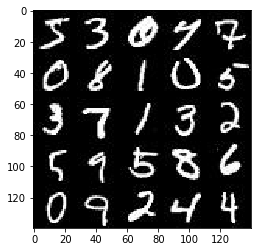

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

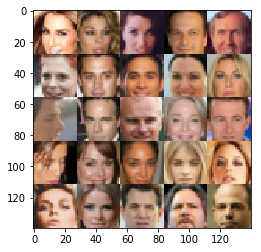

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/abdelhadi/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr') 

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    n_images = 16
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images*=2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1857... Generator Loss: 7.1525
Epoch 1/2... Discriminator Loss: 0.0218... Generator Loss: 15.6963
Epoch 1/2... Discriminator Loss: 0.0927... Generator Loss: 2.5159
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 0.8708
Epoch 1/2... Discriminator Loss: 0.1431... Generator Loss: 3.4230
Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 2.1094
Epoch 1/2... Discriminator Loss: 0.4916... Generator Loss: 6.2762
Epoch 1/2... Discriminator Loss: 0.2985... Generator Loss: 1.8992
Epoch 1/2... Discriminator Loss: 0.2984... Generator Loss: 1.7373


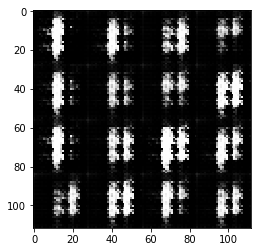

Epoch 1/2... Discriminator Loss: 0.4066... Generator Loss: 1.6186
Epoch 1/2... Discriminator Loss: 0.2405... Generator Loss: 2.4737
Epoch 1/2... Discriminator Loss: 0.2597... Generator Loss: 5.7742
Epoch 1/2... Discriminator Loss: 0.2272... Generator Loss: 3.4564
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 6.4361
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.5616
Epoch 1/2... Discriminator Loss: 0.5071... Generator Loss: 1.7662
Epoch 1/2... Discriminator Loss: 0.3246... Generator Loss: 5.7594
Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 5.1433
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 8.0431


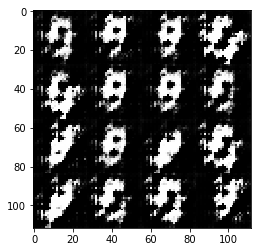

Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 3.4080
Epoch 1/2... Discriminator Loss: 0.2632... Generator Loss: 2.4075
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 0.1845... Generator Loss: 2.5669
Epoch 1/2... Discriminator Loss: 0.1112... Generator Loss: 4.1579
Epoch 1/2... Discriminator Loss: 0.1739... Generator Loss: 3.3575
Epoch 1/2... Discriminator Loss: 0.0245... Generator Loss: 4.9230
Epoch 1/2... Discriminator Loss: 0.1382... Generator Loss: 3.1276
Epoch 1/2... Discriminator Loss: 0.4363... Generator Loss: 4.4707
Epoch 1/2... Discriminator Loss: 0.1641... Generator Loss: 3.2148


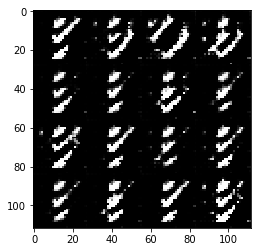

Epoch 1/2... Discriminator Loss: 0.1672... Generator Loss: 3.4519
Epoch 1/2... Discriminator Loss: 0.1746... Generator Loss: 6.8902
Epoch 1/2... Discriminator Loss: 0.1270... Generator Loss: 4.0359
Epoch 1/2... Discriminator Loss: 0.1175... Generator Loss: 2.9248
Epoch 1/2... Discriminator Loss: 0.3260... Generator Loss: 1.8551
Epoch 1/2... Discriminator Loss: 0.1663... Generator Loss: 2.6146
Epoch 1/2... Discriminator Loss: 3.3300... Generator Loss: 0.1314
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 0.7064... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 2.7852


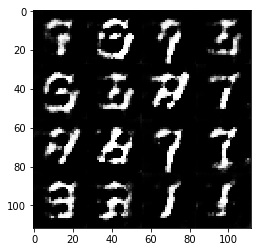

Epoch 1/2... Discriminator Loss: 0.3839... Generator Loss: 2.3972
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 2.2377
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 2.9519
Epoch 1/2... Discriminator Loss: 0.3588... Generator Loss: 2.7577
Epoch 1/2... Discriminator Loss: 2.3142... Generator Loss: 9.2395
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 2.1569
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 2.7206
Epoch 1/2... Discriminator Loss: 0.4560... Generator Loss: 3.3037
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 4.9315
Epoch 1/2... Discriminator Loss: 0.4541... Generator Loss: 2.3727


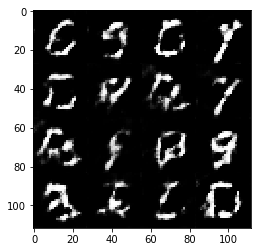

Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 3.4218
Epoch 1/2... Discriminator Loss: 0.7023... Generator Loss: 1.2710
Epoch 1/2... Discriminator Loss: 1.5448... Generator Loss: 6.4555
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.0295
Epoch 1/2... Discriminator Loss: 0.8741... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 3.6475
Epoch 1/2... Discriminator Loss: 0.7123... Generator Loss: 1.6925
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.4097
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 2.9197


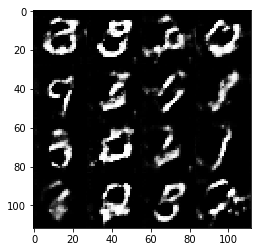

Epoch 1/2... Discriminator Loss: 0.6826... Generator Loss: 1.3840
Epoch 1/2... Discriminator Loss: 0.6102... Generator Loss: 1.6823
Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 0.4903... Generator Loss: 2.0105
Epoch 1/2... Discriminator Loss: 0.5529... Generator Loss: 2.0260
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 1.0847
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.8979
Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 1.0061
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 2.5146


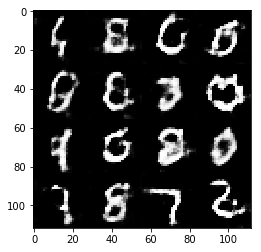

Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.6875... Generator Loss: 0.2879
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 2.4484
Epoch 1/2... Discriminator Loss: 0.9541... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 1.4401
Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 2.0195
Epoch 1/2... Discriminator Loss: 0.6531... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 1.2824


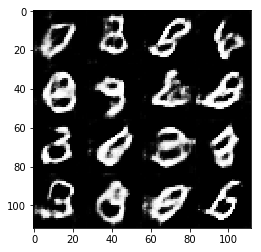

Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 2.5342
Epoch 1/2... Discriminator Loss: 0.5099... Generator Loss: 1.9379
Epoch 1/2... Discriminator Loss: 2.1370... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 2.1847
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 2.3271
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.3647
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 1.7788


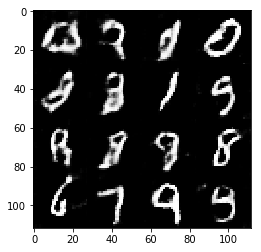

Epoch 1/2... Discriminator Loss: 0.7403... Generator Loss: 1.4445
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 2.3025
Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 1.6564
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.5307
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 1.6759
Epoch 2/2... Discriminator Loss: 0.8068... Generator Loss: 1.9082
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 1.3627
Epoch 2/2... Discriminator Loss: 1.8602... Generator Loss: 3.0916
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.7001


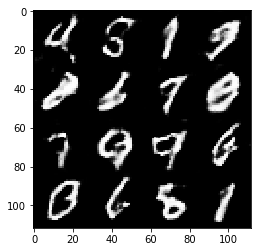

Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.5951
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 2.2857... Generator Loss: 0.1749
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.7733
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 1.5150
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.3763


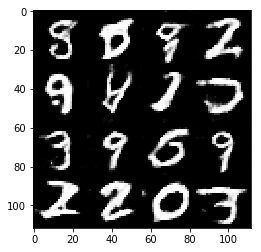

Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 2.2061
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.0783
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 2.5048
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.3731
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 0.3773
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 0.8196


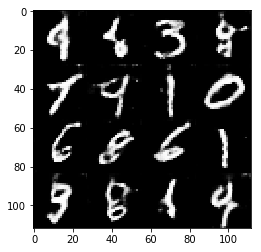

Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.1896
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 1.4232
Epoch 2/2... Discriminator Loss: 1.0691... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 0.9285
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.4379
Epoch 2/2... Discriminator Loss: 1.5419... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 1.0714
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 2.2692


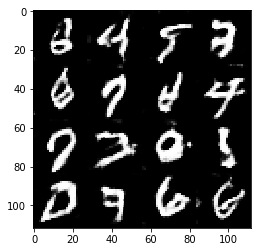

Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 1.5792... Generator Loss: 2.5515
Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 1.8102
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 1.7495
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.0210
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 2.2771
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.6028


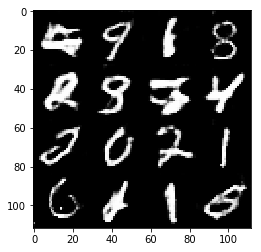

Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.2980
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 1.4490
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 1.9634
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.0126
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 1.4850
Epoch 2/2... Discriminator Loss: 0.7772... Generator Loss: 1.2975


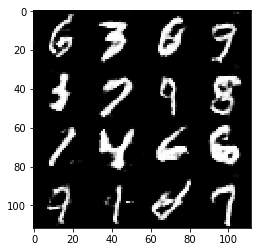

Epoch 2/2... Discriminator Loss: 1.6623... Generator Loss: 0.3442
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 0.7872... Generator Loss: 2.2333
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.2409
Epoch 2/2... Discriminator Loss: 0.6563... Generator Loss: 1.3665
Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 1.1629


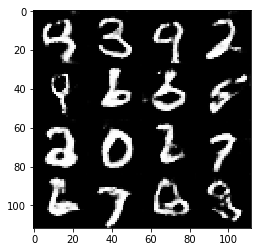

Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 1.1917
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 0.9390
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 2.2118
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.6362
Epoch 2/2... Discriminator Loss: 0.6845... Generator Loss: 1.3921
Epoch 2/2... Discriminator Loss: 0.5837... Generator Loss: 1.3994
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.4954
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.7069


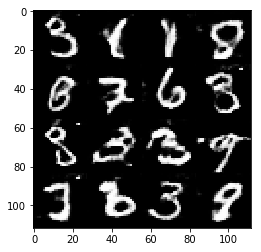

Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.8046... Generator Loss: 2.7739
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 1.2415... Generator Loss: 3.1634
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.6044
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 1.3185
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.6256


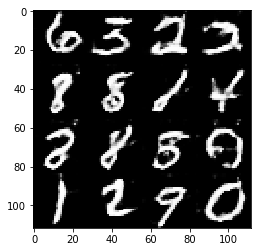

Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 3.0699
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 0.5698
Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 0.9563


In [12]:
batch_size = 64
z_dim = 100
learning_rate = .001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2083... Generator Loss: 9.8326
Epoch 1/1... Discriminator Loss: 0.1736... Generator Loss: 10.9918
Epoch 1/1... Discriminator Loss: 0.3110... Generator Loss: 13.2394
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 2.6705... Generator Loss: 0.1218
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 9.8193
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 2.9152
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 4.4993
Epoch 1/1... Discriminator Loss: 0.2608... Generator Loss: 3.0881


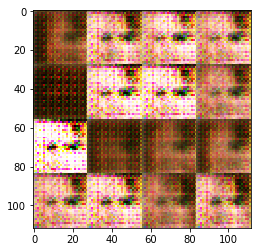

Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.6682... Generator Loss: 0.2864
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 2.8290
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.7954... Generator Loss: 3.4455
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 1.7224
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 2.2622


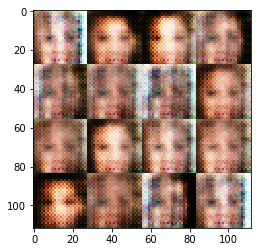

Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.5298
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 2.6507
Epoch 1/1... Discriminator Loss: 2.0502... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 2.6594


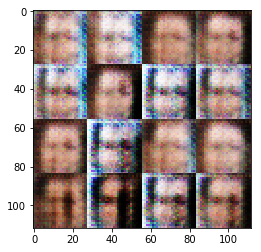

Epoch 1/1... Discriminator Loss: 2.5431... Generator Loss: 3.3664
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 1.9920
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.7024
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.7964
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 1.9208... Generator Loss: 2.5895
Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.2275


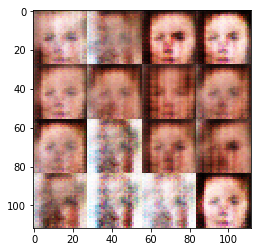

Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 2.0425
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 1.1904
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 2.1595
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.1158


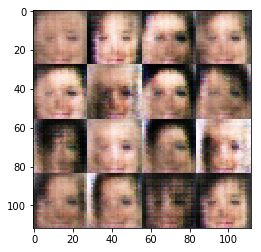

Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.4773
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 2.0185
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 2.9295
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.7273... Generator Loss: 0.2840
Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 1.7205
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.6401


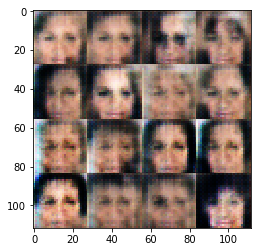

Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.9064
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.5328
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.8515
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 2.1442
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.6940


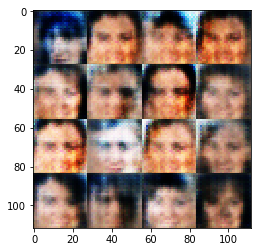

Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.7284... Generator Loss: 3.7850
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 2.1618
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 2.2563
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.4126


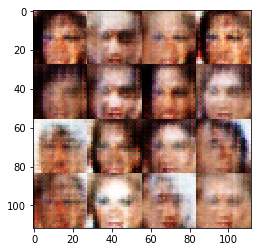

Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.8772
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.5546
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 2.3593
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.5242


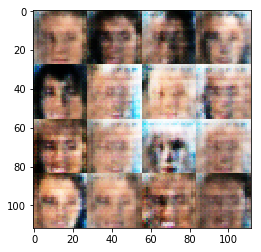

Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 2.3105
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.7278
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 2.0772


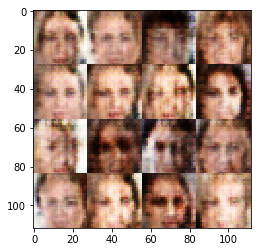

Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.7763... Generator Loss: 0.3116
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.5482
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.6657


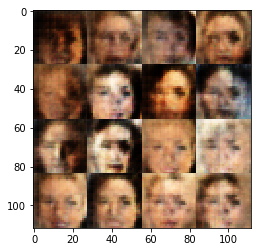

Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 2.0069
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.5044
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 0.8198


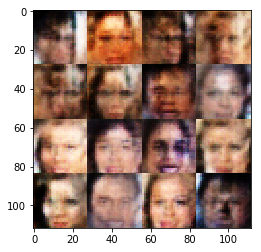

Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.4258
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.5490
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 2.6552
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 0.8765


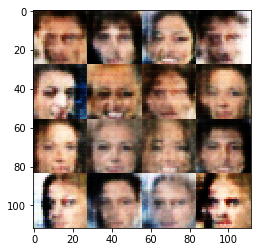

Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 2.5025
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 2.1680
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.3121


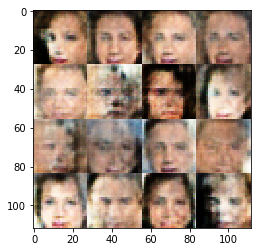

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.6954
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.5827
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 2.3149
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 2.0589
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.3545


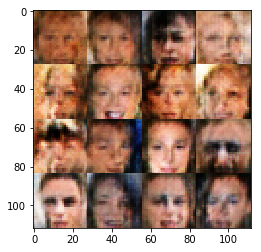

Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 2.5124
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.6881


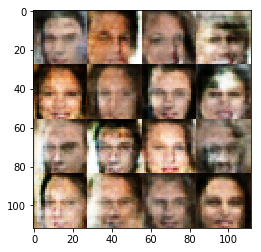

Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.8267
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.8093


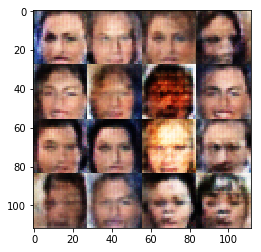

Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 2.1031
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.6941
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.7451
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.5809


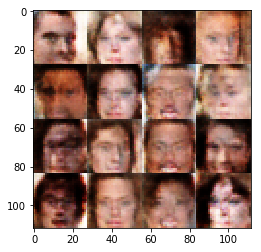

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.4462
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.1385


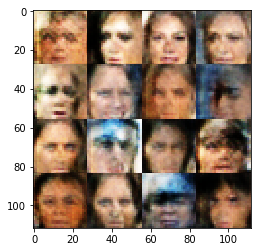

Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 2.6042
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.6667
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.1169


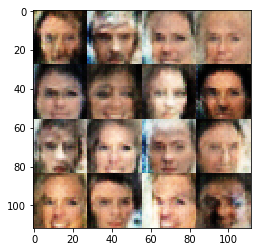

Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.3509
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 2.1792
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.7177


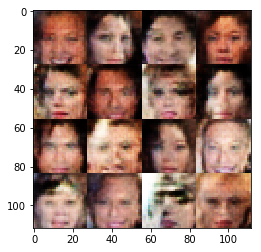

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 1.7098
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.8324


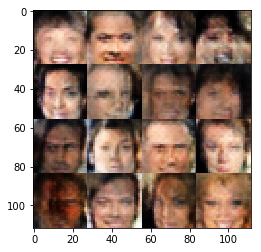

Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.4678
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.8019
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.3601


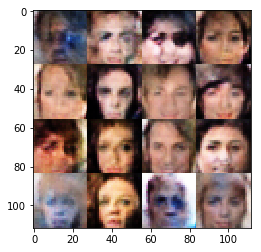

Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.6277


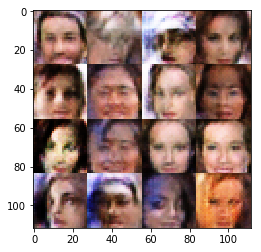

Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.5171
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.6747


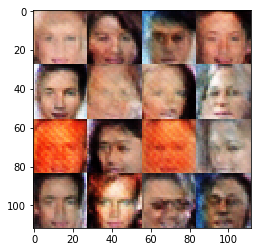

Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.3721
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.4616


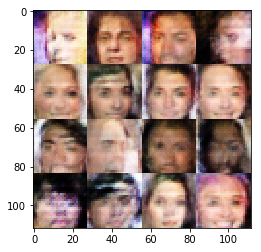

Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.7620... Generator Loss: 2.1794
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 2.0384
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.5724


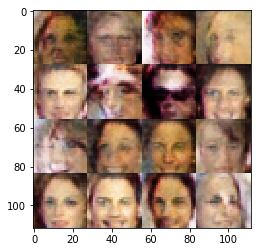

Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 0.3752


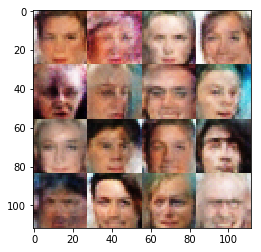

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 1.5393
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.4615


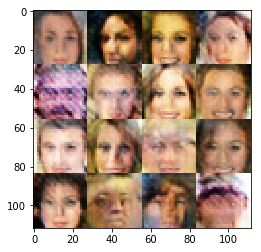

Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 1.2870


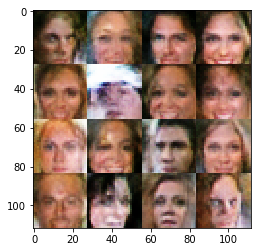

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.7039... Generator Loss: 0.2952
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8350


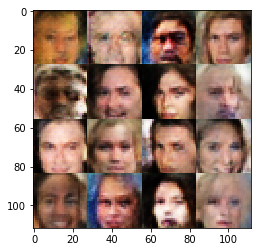

Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.9208


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.